# Large Scale Image Denoising with Manifold Traversal

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import pickle


from helper_images import image_to_patches, patches_to_image_with_positions, load_images, preprocess_images, get_patches_from_images, flatten_patches



import sys
sys.path.insert(0, '/data/shiyu/projects/MT/MT_ICML_OOP')
from models.manifold_traversal import ManifoldTraversal


import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]  
})

# load data

In [3]:
image_dir = '/data/shiyu/projects/MT/MT_ICML_OOP/data/image_data/ImageNet'
images, filenames = load_images(image_dir)
print(f"Loaded {len(images)} images")

Loaded n02102040_1329.JPEG with shape (375, 500, 3)
Loaded n02102040_3837.JPEG with shape (333, 500, 3)
Loaded n02102040_759.JPEG with shape (500, 376, 3)
Loaded n02102040_3923.JPEG with shape (400, 500, 3)
Loaded n02102040_3225.JPEG with shape (333, 500, 3)
Loaded n02102040_3496.JPEG with shape (335, 500, 3)
Loaded n02102040_4679.JPEG with shape (480, 360, 3)
Loaded n02102040_875.JPEG with shape (375, 500, 3)
Loaded n02102040_468.JPEG with shape (346, 500, 3)
Loaded n02102040_8126.JPEG with shape (377, 500, 3)
Loaded n02102040_76.JPEG with shape (333, 500, 3)
Loaded n02102040_7517.JPEG with shape (471, 500, 3)
Loaded n02102040_2326.JPEG with shape (375, 500, 3)
Loaded n02102040_4956.JPEG with shape (360, 351, 3)
Loaded n02102040_738.JPEG with shape (375, 500, 3)
Loaded n02102040_1305.JPEG with shape (480, 640, 3)
Loaded n02102040_3255.JPEG with shape (614, 493, 3)
Loaded n02102040_7406.JPEG with shape (375, 500, 3)
Loaded n02102040_1238.JPEG with shape (400, 500, 3)
Loaded n02102040_1

# Process Images

In [4]:
sigma = 0.1 #noise level


orig_img_scaled, img_scaled, noisy_images, clean_images = preprocess_images(images=images, start_idx=0, num_imgs=300, sigma=sigma)
clean_patches, noisy_patches, clean_positions, noisy_positions, N_patches_per_img = get_patches_from_images(clean_images=clean_images, noisy_images=noisy_images, patch_size=8, stride=8)
clean_patches_flattened, noisy_patches_flattened = flatten_patches(clean_patches=clean_patches, noisy_patches=noisy_patches)


#shuffle the data
permutation = np.random.permutation(len(noisy_patches_flattened))
shuffled_clean_patches = clean_patches_flattened[permutation, :]
shuffled_noisy_patches = noisy_patches_flattened[permutation, :]


# each col is a point
X_train = shuffled_noisy_patches.T
X_natural_train = shuffled_clean_patches.T
N_train = X_train.shape[1]
print(f'N_train = {N_train}')


#dimensions
D = clean_patches[0].shape[1] * clean_patches[0].shape[2] * clean_patches[0].shape[3]
d = 4

print(f'D = {D}, d = {d}')

Total number of original images: len(img_scaled_orig) = 955
Total number of RGB images: len(img_scaled) for training = 300
Number of clean images: len(clean_images) = 300
Number of noisy images: len(noisy_images) = 300
Number of total patches in noisy images: 894262
N_train = 894262
D = 192, d = 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44374788895580297..1.421429439277961].


idx_r =  152
N_previous_patches =  2542
N_cur_patch =  2756
N_patches_til_now =  454260
N_patches_til_now + N_cur_patch =  457016
img_scaled[idx_r].shape =  (421, 427, 3)


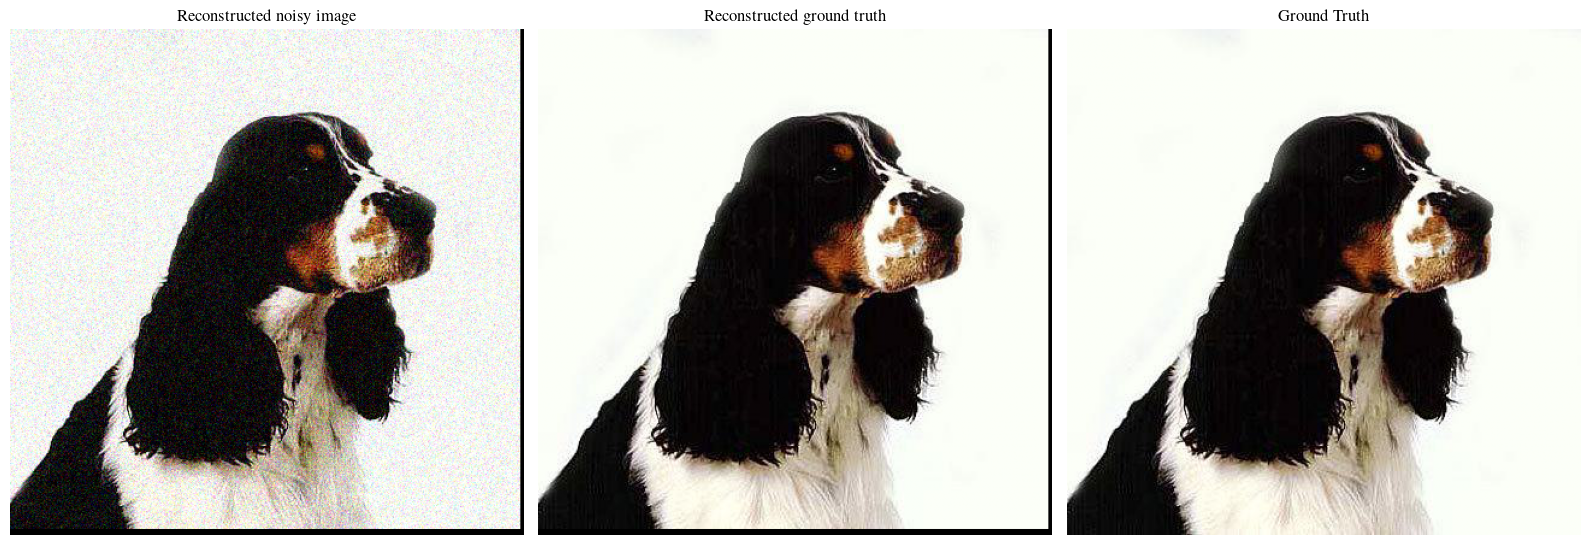

In [5]:
# Reconstruct one image to sanity check


idx_r = np.random.randint(0, len(noisy_images))
print('idx_r = ', idx_r)



print('N_previous_patches = ', N_patches_per_img[idx_r-1])
N_cur_patch = N_patches_per_img[idx_r]
print('N_cur_patch = ', N_cur_patch)


N_patches_til_now = int(np.sum(N_patches_per_img[:idx_r]))

print('N_patches_til_now = ', N_patches_til_now)
print('N_patches_til_now + N_cur_patch = ', N_patches_til_now + N_cur_patch)



print('img_scaled[idx_r].shape = ', img_scaled[idx_r].shape)
image_height = img_scaled[idx_r].shape[0]
image_width = img_scaled[idx_r].shape[1]



# convert currrent vector patches to patches
cur_list = (noisy_patches_flattened[N_patches_til_now: N_patches_til_now + N_cur_patch, :]).reshape(-1, 8, 8, 3)
cur_clean_list = (clean_patches_flattened[N_patches_til_now: N_patches_til_now + N_cur_patch, :]).reshape(-1, 8, 8, 3)



# get reconstructed images from patches
rec_noisy_img = patches_to_image_with_positions(cur_list, noisy_positions[idx_r], image_height, image_width)
rec_clean_img = patches_to_image_with_positions(cur_clean_list, clean_positions[idx_r], image_height, image_width)




plt.figure(figsize = (16, 10))
plt.subplot(131)
plt.imshow(rec_noisy_img)
plt.title('Reconstructed noisy image')
plt.axis('off')

plt.subplot(132)
plt.imshow(rec_clean_img)
plt.title('Reconstructed ground truth')
plt.axis('off')

plt.subplot(133)
plt.imshow(clean_images[idx_r])
plt.title('Ground Truth')
plt.axis('off')


plt.tight_layout()
plt.show()

# train MT

In [6]:
mt = ManifoldTraversal(
    intrinsic_dim=d,
    ambient_dim=D,
    sigma=sigma,
    R_denoising=2.5,
    R_1st_order_nbhd=3,
    R_is_const=True,
    d_parallel=np.sqrt(20 * sigma**2 * d),
    prod_coeff=1.2,
    exp_coeff=0.5
)

In [7]:
results = mt.fit(X_train, X_natural_train, batch_size=4000, verbose=True)

Training manifold traversal on 894262 samples...
4000 samples processed (batch time: 3.48s)
8000 samples processed (batch time: 6.20s)
12000 samples processed (batch time: 8.34s)
16000 samples processed (batch time: 9.87s)
20000 samples processed (batch time: 11.55s)
24000 samples processed (batch time: 13.24s)
28000 samples processed (batch time: 14.68s)
32000 samples processed (batch time: 16.51s)
36000 samples processed (batch time: 19.09s)
40000 samples processed (batch time: 21.04s)
44000 samples processed (batch time: 21.76s)
48000 samples processed (batch time: 23.02s)
52000 samples processed (batch time: 25.79s)
56000 samples processed (batch time: 26.88s)
60000 samples processed (batch time: 28.23s)
64000 samples processed (batch time: 27.92s)
68000 samples processed (batch time: 31.07s)
72000 samples processed (batch time: 32.18s)
76000 samples processed (batch time: 34.70s)
80000 samples processed (batch time: 35.40s)
84000 samples processed (batch time: 36.19s)
88000 sample

In [8]:
save_path = '/data/shiyu/projects/MT/MT_ICML_OOP/images/trained_MT_large_scale_images.pkl'

with open(save_path, 'wb') as f:
    pickle.dump(results, f)

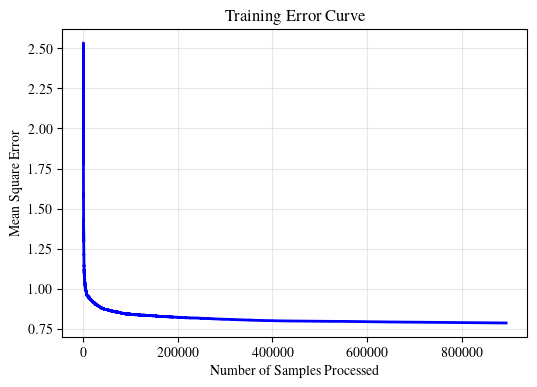

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(results.mean_MT_error, 'b-', linewidth=2)
plt.xlabel('Number of Samples Processed')
plt.ylabel('Mean Square Error')
plt.title('Training Error Curve')
plt.grid(True, alpha=0.3)


save_path = '/data/shiyu/projects/MT/MT_ICML_OOP/images/results_image/large_scale_training_error_curve.pdf'
if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches='tight')

## Test noisy image

In [10]:
num_imgs  = 1
# idx_test  = len(noisy_images) + 10
idx_test = 829
print(f'idx_test = {idx_test}')

orig_img_scaled, img_scaled, noisy_images, clean_images = preprocess_images(images=images, start_idx=idx_test, num_imgs=num_imgs, sigma=sigma)
clean_patches, noisy_patches, clean_positions, noisy_positions, N_patches_per_img = get_patches_from_images(clean_images=clean_images, noisy_images=noisy_images, patch_size=8, stride=8)
clean_patches_flattened, noisy_patches_flattened = flatten_patches(clean_patches=clean_patches, noisy_patches=noisy_patches)

if num_imgs == 1:
    idx_test = 0

# each col is a point
X_test = noisy_patches_flattened.T
X_natural_test = clean_patches_flattened.T
N_test = X_test.shape[1]
print(f'N_train = {N_test}')

idx_test = 829
Total number of original images: len(img_scaled_orig) = 955
Total number of RGB images: len(img_scaled) for training = 1
Number of clean images: len(clean_images) = 1
Number of noisy images: len(noisy_images) = 1
Number of total patches in noisy images: 2542
N_train = 2542


In [11]:


denoised_patches_flattened = np.zeros(noisy_patches_flattened.shape)



for n in range(N_test):
    x = noisy_patches_flattened[n,:]
    x_mt_hat = mt.denoise(x)
    denoised_patches_flattened[n,:] = x_mt_hat

denoised_patches = denoised_patches_flattened.reshape(-1, 8, 8, 3)


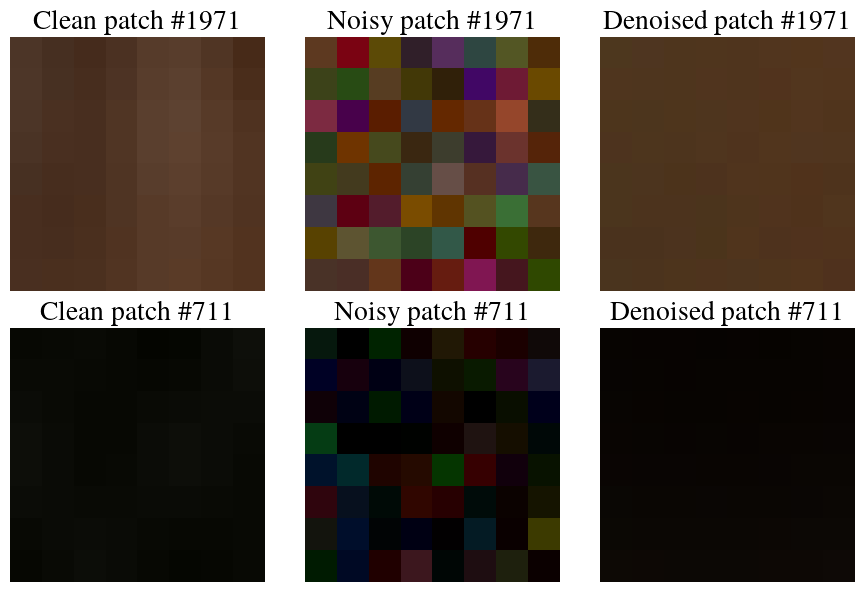

In [12]:

# idx1 = np.random.randint(0, N_test)
# idx2 = np.random.randint(0, N_test)

idx1 = 1971
idx2 = 711



plt.figure(figsize=(9,6))

plt.subplot(231)
plt.imshow(np.clip(clean_patches[idx_test][idx1],0.0,1.0))
plt.title(r'Clean patch $\#%d$' % idx1, fontsize=20)
plt.axis('off')

plt.subplot(232)
plt.imshow(np.clip(noisy_patches[idx_test][idx1],0.0,1.0))
plt.title(r'Noisy patch $\#%d$' % idx1, fontsize=20)
plt.axis('off')

plt.subplot(233)
plt.imshow(np.clip(denoised_patches[idx1],0.0,1.0))
plt.title(r'Denoised patch $\#%d$' % idx1, fontsize=20)
plt.axis('off')

plt.subplot(234)
plt.imshow(np.clip(clean_patches[idx_test][idx2],0.0,1.0))
plt.title(r'Clean patch $\#%d$' % idx2, fontsize=20)
plt.axis('off')

plt.subplot(235)
plt.imshow(np.clip(noisy_patches[idx_test][idx2],0.0,1.0))
plt.title(r'Noisy patch $\#%d$' % idx2, fontsize=20)
plt.axis('off')

plt.subplot(236)
plt.imshow(np.clip(denoised_patches[idx2],0.0,1.0))
plt.title(r'Denoised patch $\#%d$' % idx2, fontsize=20)
plt.axis('off')
plt.tight_layout()



save_path = '/data/shiyu/projects/MT/MT_ICML_OOP/images/results_image/large_scale_patches.pdf'

if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches="tight")

noisy-orig-sqdist - denoised-orig-sqdist is 3584.7398470167836
clip-noisy-orig-sqdist - clip-denoised-orig-sqdist is 2904.878523878846
--------------------------------------------------------------------------------------------------


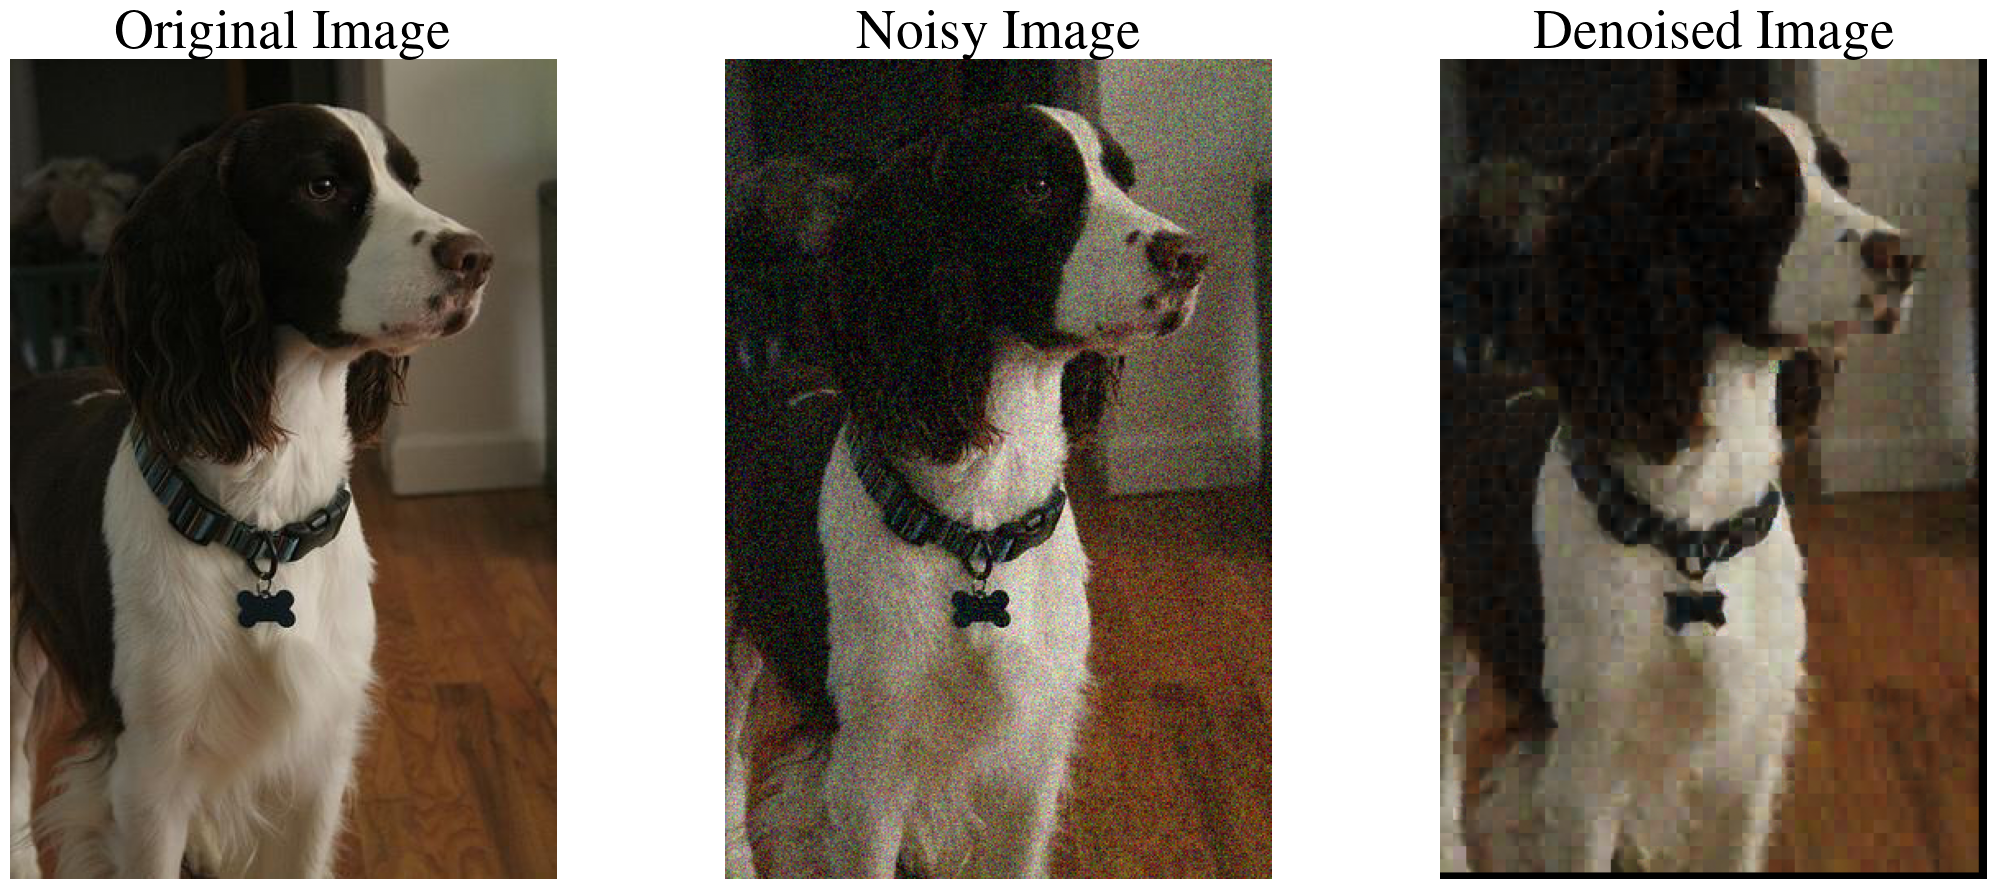

In [13]:
img_scaled_clip = np.clip(img_scaled, 0.0, 1.0)
noisy_img_clip = np.clip(noisy_images, 0.0, 1.0)






denoised_image = patches_to_image_with_positions(denoised_patches, noisy_positions[idx_test], img_scaled[idx_test].shape[0], img_scaled[idx_test].shape[1])

denoised_image_clip = np.clip(denoised_image, 0.0, 1.0)


noisy_orig_sqdist_denoised_orig_sqdist = np.sum((img_scaled[idx_test] - noisy_images[idx_test])**2) - np.sum((img_scaled[idx_test] - denoised_image)**2)
clip_noisy_orig_sqdist_denoised_orig_sqdist = np.sum((img_scaled_clip[idx_test] - noisy_img_clip[idx_test])**2) - np.sum((img_scaled_clip[idx_test] - denoised_image_clip)**2)




print(f'noisy-orig-sqdist - denoised-orig-sqdist is {noisy_orig_sqdist_denoised_orig_sqdist}')
print(f'clip-noisy-orig-sqdist - clip-denoised-orig-sqdist is {clip_noisy_orig_sqdist_denoised_orig_sqdist}')
print('--------------------------------------------------------------------------------------------------')

plt.figure(figsize=(22, 9))

plt.subplot(1, 3, 1)
plt.imshow(img_scaled_clip[idx_test])
plt.title(r'Original Image', fontsize=40) 
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_img_clip[idx_test])
plt.title(r'Noisy Image', fontsize=40) 
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image_clip)
plt.title(r'Denoised Image', fontsize=40)  
plt.axis('off')
plt.tight_layout()


save_path = '/data/shiyu/projects/MT/MT_ICML_OOP/images/results_image/large_scale_images.pdf'
if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches="tight")
